# Experiment: Monte Carlo Validation Workflow

This notebook demonstrates a minimal Monte Carlo validation workflow using `jetobsmc`.
We generate two synthetic generator-like jet samples (MC-A and MC-B), compute a standardized panel of jet observables,
and quantify distribution shifts via KS distances suitable for downstream comparison and plotting.


In [1]:
# Setup: imports and reproducibility
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np

_root = Path().resolve()
if not (_root / "jet_observables").exists():
    _root = _root.parent
sys.path.insert(0, str(_root / "jet_observables"))

from jetobsmc.jet import Jet
from jetobsmc.observables import (
    energy_correlation_e2,
    jet_width,
    mass,
    nsubjettiness_tau21,
    pt,
    pt_dispersion,
    soft_drop_zg_proxy,
)

SEED = 123
rng = np.random.default_rng(SEED)
plt.style.use("seaborn-v0_8-whitegrid")

print("Seed:", SEED)
print("Python path root:", _root)


Seed: 123
Python path root: /Users/atharva/Documents/Code/ML4SCI/jet-observables-lib


## Plan

- Build two synthetic Monte Carlo samples with controlled shifts in constituent-level radiation patterns.
- Compute a unified observable panel for each jet in both samples.
- Compare samples with summary statistics and KS distances.
- Visualize representative distributions for quick physics diagnostics.


In [2]:
# Define parameters and lightweight helpers
N_JETS = 2500


def sample_jet(pt_scale: float, eta_spread: float) -> Jet:
    n_const = int(rng.poisson(18)) + 3
    pt_i = rng.exponential(scale=pt_scale, size=n_const) + 0.2
    eta_i = rng.normal(loc=0.0, scale=eta_spread, size=n_const)
    phi_i = rng.uniform(-np.pi, np.pi, size=n_const)

    px = pt_i * np.cos(phi_i)
    py = pt_i * np.sin(phi_i)
    pz = pt_i * np.sinh(eta_i)
    e = pt_i * np.cosh(eta_i)  # massless constituent approximation

    p4 = np.column_stack([e, px, py, pz])
    return Jet(p4)


def make_sample(n_jets: int, pt_scale: float, eta_spread: float) -> list[Jet]:
    return [sample_jet(pt_scale=pt_scale, eta_spread=eta_spread) for _ in range(n_jets)]


jets_a = make_sample(N_JETS, pt_scale=5.5, eta_spread=0.38)
jets_b = make_sample(N_JETS, pt_scale=6.2, eta_spread=0.48)

obs_fns = {
    "jet_pt": pt,
    "jet_mass": mass,
    "jet_width": jet_width,
    "ptd": pt_dispersion,
    "tau21": nsubjettiness_tau21,
    "e2": energy_correlation_e2,
    "zg_proxy": soft_drop_zg_proxy,
}

obs_a = {name: np.array([fn(j) for j in jets_a], dtype=float) for name, fn in obs_fns.items()}
obs_b = {name: np.array([fn(j) for j in jets_b], dtype=float) for name, fn in obs_fns.items()}


def ks_distance(x: np.ndarray, y: np.ndarray) -> float:
    x = np.sort(np.asarray(x, dtype=float))
    y = np.sort(np.asarray(y, dtype=float))

    values = np.sort(np.unique(np.concatenate([x, y])))
    cdf_x = np.searchsorted(x, values, side="right") / x.size
    cdf_y = np.searchsorted(y, values, side="right") / y.size
    return float(np.max(np.abs(cdf_x - cdf_y)))


ks = {name: ks_distance(obs_a[name], obs_b[name]) for name in obs_fns}


## Results

The table and plots below provide a compact MC-vs-MC validation snapshot.
Higher KS distance indicates stronger disagreement between the two samples for that observable.


Observable summary (MC-A vs MC-B)
name        mean_A     mean_B     KS
----------------------------------------
jet_pt       31.9445   35.3874  0.0856
jet_mass    122.4605  142.7622  0.2124
jet_width     1.3846    1.4591  0.0932
ptd           0.3005    0.2994  0.0156
tau21         0.6150    0.6245  0.0508
e2          12005.1623  15463.4931  0.1760
zg_proxy      0.4259    0.4231  0.0360


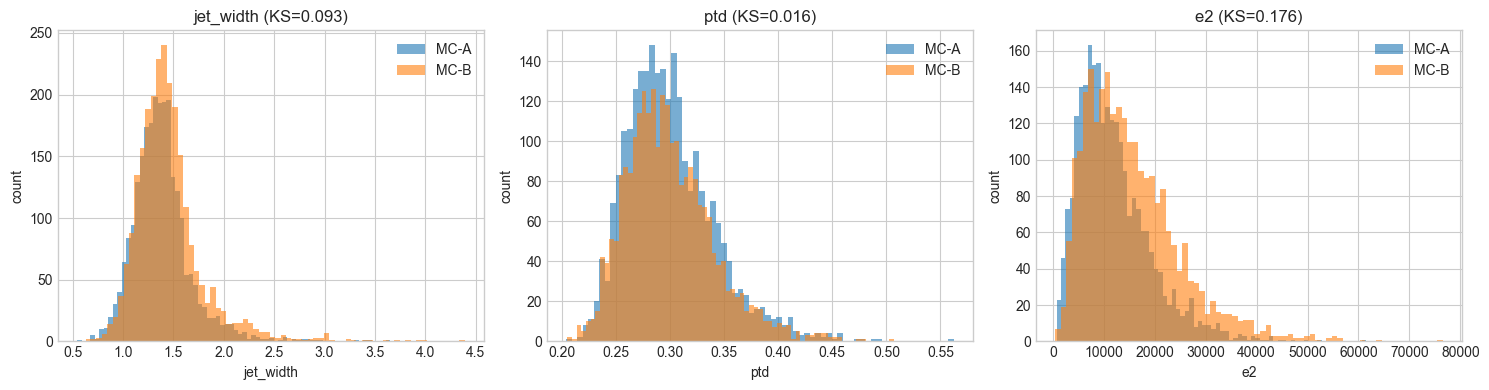

{'n_jets_per_sample': 2500,
 'observables': {'jet_pt': {'mean_a': 31.944482728827918,
   'mean_b': 35.387393001363385,
   'ks_distance': 0.08560000000000001},
  'jet_mass': {'mean_a': 122.46051113399015,
   'mean_b': 142.762207060468,
   'ks_distance': 0.21240000000000003},
  'jet_width': {'mean_a': 1.3845550471875145,
   'mean_b': 1.4590770118135215,
   'ks_distance': 0.09319999999999995},
  'ptd': {'mean_a': 0.30046739199325917,
   'mean_b': 0.29942481379840946,
   'ks_distance': 0.015600000000000058},
  'tau21': {'mean_a': 0.6149956297497867,
   'mean_b': 0.6244697869874706,
   'ks_distance': 0.05080000000000001},
  'e2': {'mean_a': 12005.16234245423,
   'mean_b': 15463.49307613777,
   'ks_distance': 0.17600000000000005},
  'zg_proxy': {'mean_a': 0.42593094987245256,
   'mean_b': 0.42305548656566955,
   'ks_distance': 0.03600000000000003}}}

In [3]:
# Record findings in a minimal, copy-pasteable structure
print("Observable summary (MC-A vs MC-B)")
print("name        mean_A     mean_B     KS")
print("----------------------------------------")
for name in obs_fns:
    print(f"{name:10s}  {obs_a[name].mean():8.4f}  {obs_b[name].mean():8.4f}  {ks[name]:6.4f}")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
plot_names = ["jet_width", "ptd", "e2"]
for ax, name in zip(axes, plot_names):
    ax.hist(obs_a[name], bins=70, alpha=0.6, label="MC-A")
    ax.hist(obs_b[name], bins=70, alpha=0.6, label="MC-B")
    ax.set_title(f"{name} (KS={ks[name]:.3f})")
    ax.set_xlabel(name)
    ax.set_ylabel("count")
    ax.legend()

plt.tight_layout()
plt.show()

comparison_payload = {
    "n_jets_per_sample": N_JETS,
    "observables": {
        name: {
            "mean_a": float(obs_a[name].mean()),
            "mean_b": float(obs_b[name].mean()),
            "ks_distance": float(ks[name]),
        }
        for name in obs_fns
    },
}

comparison_payload


## Next steps

- Replace synthetic jets with public datasets (e.g., HEPSIM/LHC-style event records).
- Export comparison payloads to disk (`.csv`/`.json`) for plotting dashboards.
- Add reference generator comparisons and uncertainty bands.
